In [1]:
import gpxpy
import gpxpy.gpx

import geopy
from geopy import distance

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
coords_1 = (47.238047, 7.659688)
coords_2 = (47.238050, 7.659700)

distance.distance(coords_1, coords_2).m
# (lat, lon) <- this is important

0.9678909151314868

### load & create metrics

In [32]:
gpx_file = open('data/activity_6321809225.gpx', 'r') # 23.02.2021

In [ ]:
gpx_file = open('data/activity_6374486103.gpx', 'r') # 04.03.2021
#gpx_file = open('data/test.gpx', 'r') # control file. must not be identical to activity_6374486103.gpx

In [27]:
gpx_file = open('data/activity_6403188314.gpx', 'r') # 09.03.2021

In [22]:
gpx_file = open('data/activity_6451992907.gpx', 'r') # 18.03.2021

In [12]:
gpx_file = open('data/activity_8215567101.gpx', 'r') # 31.01.2022

In [11]:
gpx_file = open('data/activity_8261617947.gpx', 'r') # 08.02.2022

In [14]:
gpx_file = open('data/activity_8341689902.gpx', 'r') # 22.02.2022

In [21]:
gpx_file = open('data/activity_8382045578.gpx', 'r') # 01.03.2022

In [22]:
gpx = gpxpy.parse(gpx_file)

cols = ['time', 'lat', 'lon', 'ele']
lst = []


for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lst.append([point.time,
                       point.latitude,
                       point.longitude,
                       point.elevation])
            #print('Point at ({0},{1}) -> {2} -> {3}'.format(point.latitude, point.longitude, point.elevation, point.time))
            
df = pd.DataFrame(lst, columns = cols)

In [23]:
df.loc[0, 'distance'] = 0
df.loc[0, 'timedelta'] = 1
df.loc[0, 'timefromstart'] = 0
df.loc[0, 'distancefromstart'] = 0
for i in range(1, len(df)):
    coords_1 = (df.loc[i-1, 'lat'], df.loc[i-1, 'lon'])
    coords_2 = (df.loc[i, 'lat'], df.loc[i, 'lon'])
    df.loc[i, 'distance'] = geopy.distance.distance(coords_1, coords_2).m
    
    df.loc[i, 'timedelta'] = (df.loc[i, 'time'] - df.loc[i-1, 'time']).seconds
    
    df.loc[i, 'timefromstart'] = (df.loc[i - 1, 'timefromstart'] + df.loc[i, 'timedelta'])
    
    df.loc[i, 'distancefromstart'] = (df.loc[i - 1, 'distancefromstart'] + df.loc[i, 'distance'])

df['speed'] = df.distance/df.timedelta*3.6
df['timedelta'] = df.timedelta.astype('int')
df['speed_ma'] = df['speed'].rolling(2).mean()
df = df[0:-1]
df

,time,lat,lon,ele,distance,timedelta,timefromstart,distancefromstart,speed,speed_ma
0,2022-03-01 18:31:04+00:00,47.237618,7.660813,418.399994,0.000000,1,0.0,0.000000,0.000000,NaN
1,2022-03-01 18:31:05+00:00,47.237616,7.660812,418.399994,0.159557,1,1.0,0.159557,0.574404,0.287202
2,2022-03-01 18:31:08+00:00,47.237624,7.660841,418.600006,2.352624,3,4.0,2.512181,2.823149,1.698776
3,2022-03-01 18:31:10+00:00,47.237626,7.660856,418.600006,1.149850,2,6.0,3.662031,2.069730,2.446440
4,2022-03-01 18:31:12+00:00,47.237634,7.660865,418.600006,1.061644,2,8.0,4.723675,1.910959,1.990345
...,...,...,...,...,...,...,...,...,...,...
1496,2022-03-01 20:10:00+00:00,47.237355,7.661127,419.200012,5.372956,5,5936.0,4775.845158,3.868528,2.105997
1497,2022-03-01 20:10:05+00:00,47.237309,7.661103,419.200012,5.474431,5,5941.0,4781.319589,3.941590,3.905059
1498,2022-03-01 20:10:13+00:00,47.237302,7.661075,419.200012,2.226000,8,5949.0,4783.545588,1.001700,2.471645
1499,2022-03-01 20:10:17+00:00,47.237309,7.661081,419.200012,0.811566,4,5953.0,4784.357155,0.730410,0.866055


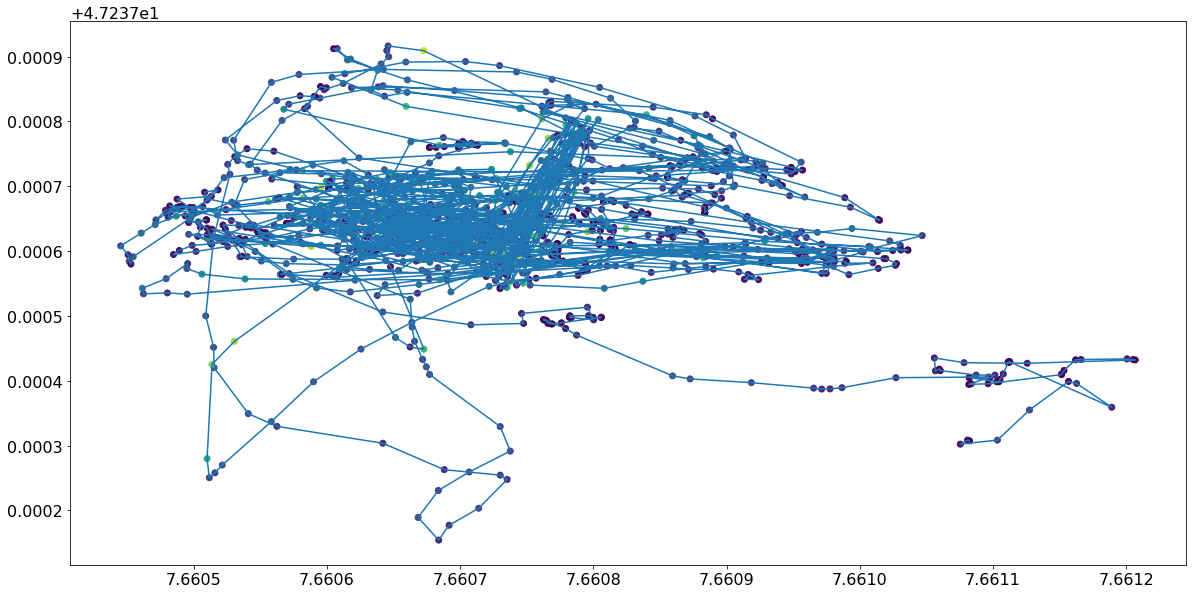

In [24]:
ax = plt.figure(figsize = (20, 10))

plt.scatter(df.lon, df.lat, c = df.speed)
plt.plot(df.lon, df.lat)
plt.show()

### speed

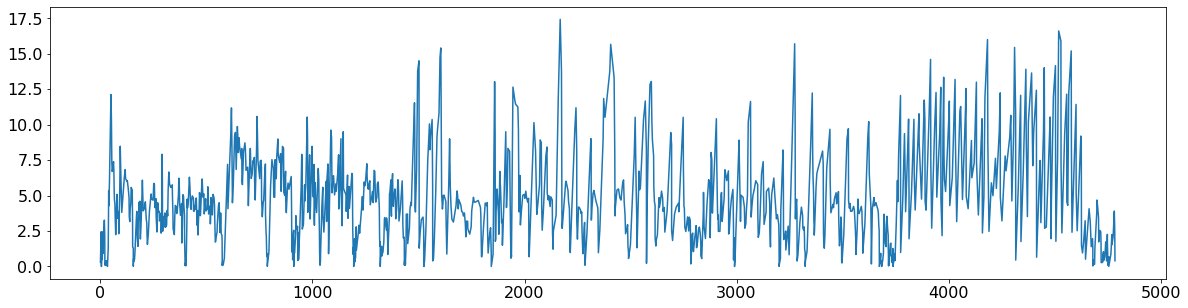

In [25]:
x = df['distancefromstart']
y = df['speed_ma']


fig = plt.figure(figsize = (20,5))
ax = plt.axes()

ax.plot(x,y)
plt.show()

### number of sprints

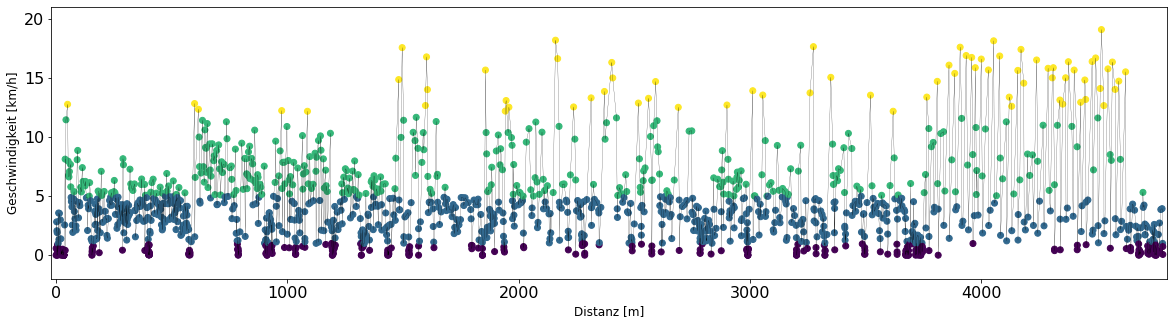

58 Sprints während total 194 Sekunden
Maximalgeschwindigkeit: 19.11km/h


In [26]:
def plot_by_zone(df, x_col = 'timefromstart', y_col = 'speed'):

    # classify zone
    # 0 -> standing (speed below 1)
    # 1 -> walking (speed 1...maxwalk)
    # 2 -> jogging (speed maxwalk..maxjog)
    # 3 -> sprinting (speed above 15)

    maxwalk = 5
    maxjog = 12
    for i in range(0, len(df)):
        if df.loc[i, y_col] < 1:
            df.loc[i, 'zone'] = 0
        elif df.loc[i, y_col] < maxwalk:
            df.loc[i, 'zone'] = 1
        elif df.loc[i, y_col] < maxjog:
            df.loc[i, 'zone'] = 2
        else:
            df.loc[i, 'zone'] = 3

    count = 0
    flag = 0
    for i in range(0, len(df)):
        if (df.loc[i, y_col] > maxjog) & (flag == 0):
            count += 1
            flag = 1
        if (df.loc[i, y_col] < maxjog) & (flag == 1):
            flag = 0

    time_in_sprint = df[df[y_col] > maxjog]['timedelta'].sum()

    fig = plt.figure(figsize = (20,5))
    ax = plt.axes()

    ax.scatter(data = df,
                         x = x_col,
                         y = y_col,
                         c = 'zone')
    ax.plot(df[x_col], df[y_col], color = 'black', linewidth=0.2)
    
    if x_col == 'distancefromstart':
        plt.xlabel('Distanz [m]', size = 12)
    elif x_col == 'timefromstart':
        plt.xlabel('Zeit [s]', size = 12)
    plt.ylabel('Geschwindigkeit [km/h]', size = 12)
    plt.ylim(-2,df[y_col].max()*1.1)
    plt.xlim(-20,df[x_col].max() + 20)
    plt.show()

    print('{0} Sprints während total {1} Sekunden'.format(count, time_in_sprint))
    print('Maximalgeschwindigkeit: {:.2f}km/h'.format(df[y_col].max()))

plot_by_zone(df, x_col = 'distancefromstart', y_col = 'speed')

### distance & time per zone

In [20]:
df_zones = df.groupby('zone').sum().drop(columns = ['lat', 'lon', 'ele', 'timefromstart', 'speed','speed_ma'])
labels = ['Zone 0 -> Stillstand', 'Zone 1 -> Gehen', 'Zone 2 -> Jogging', 'Zone 3 -> Sprint']
plt.rcParams.update({'font.size': 16})
cols = ['mediumseagreen', 'royalblue', 'sandybrown', 'indianred']

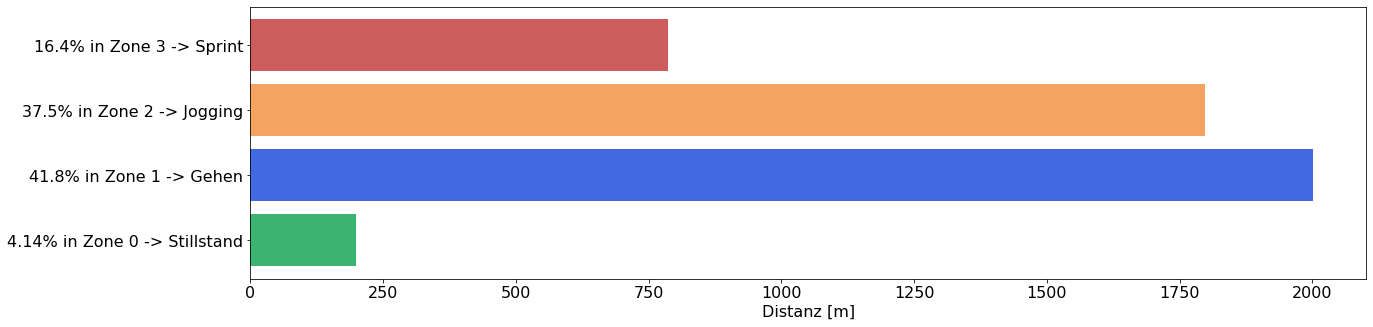

In [12]:
y = 'distance'

fig = plt.figure(figsize = (20,5))
ax = plt.axes()

total = df_zones[y].sum()

percentages = df_zones[y]/total
labels_perc = [str(y*100)[0:4] + '% in ' + x for x, y in zip(labels, list(percentages))]

ax.barh(labels_perc, df_zones['distance'], color = cols)

plt.xlabel('Distanz [m]')
plt.show()

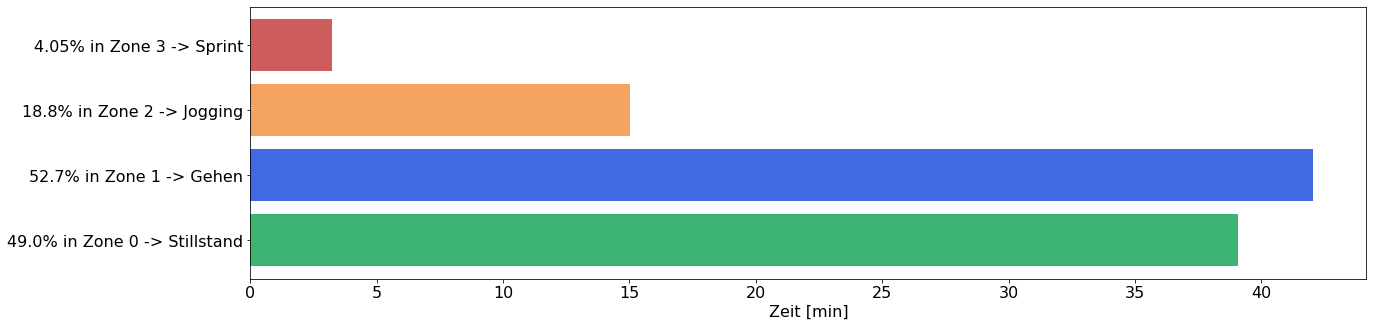

In [13]:
y = 'timedelta'

fig = plt.figure(figsize = (20,5))
ax = plt.axes()

percentages = df_zones[y]/total
labels_perc = [str(y*100)[0:4] + '% in ' + x for x, y in zip(labels, list(percentages))]

ax.barh(labels_perc, df_zones[y]/60, color = cols)

plt.xlabel('Zeit [min]')
plt.show()

### special analysis

In [94]:
df_chase = df[(df['timefromstart'] > 630) & (df['timefromstart'] < 1275)]
ind_new = np.arange(0, len(df_chase))
df_chase = df_chase.set_index(ind_new)
df_chase['timefromstart'] = df_chase['timefromstart'] - df_chase.loc[0, 'timefromstart']

In [95]:
chase_dist = df_chase.distance.sum()/1000
chase_time = df_chase.timefromstart.max()/60
chase_time_min = int(chase_time/chase_dist)
chase_time_sec = int((chase_time/chase_dist - chase_time_min)*60)

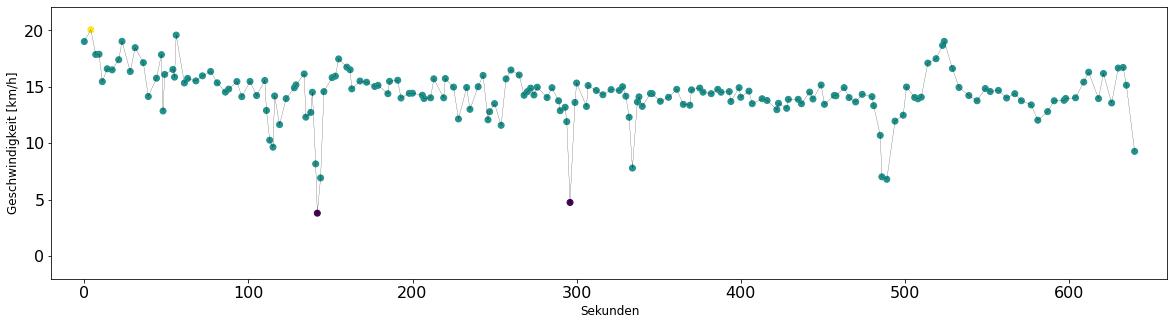

1 Sprints während total 4 Sekunden
Maximalgeschwindigkeit: 20.06km/h
2.59 Kilometer in 10.67 Minuten. Pace = 4min 7sec


In [101]:
plot_by_zone(df_chase)
print('{:.2f} Kilometer in {:.2f} Minuten. Pace = {}min {}sec'.format(chase_dist, chase_time, chase_time_min, chase_time_sec))